## Extractive Summerization

In [106]:
# import libraries
from collections import Counter
from itertools import combinations
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
from nltk import word_tokenize, sent_tokenize, FreqDist,pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import RegexpTokenizer
from operator import itemgetter
import re
%matplotlib inline

In [107]:
# Convergence threshold is the maximum error in score convergence of TextRank
CONVERGENCE_THRESHOLD = 0.0001

In [108]:
# set of all nouns
NOUNS = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}

In [163]:
class Document():
    '''
    The master class for our Document Summerization module.
    Incorporates all features related to Document
    '''
    
    def __init__(self, document):
        self.document = document
        self.sents = self.document.split('.')
        self.data = ['.'.join(self.sents[i:i+3]) for i in range(0,len(self.sents),3)]
        self.word_freq = FreqDist(clean(self.document))
        self.imp_sents = tf_idf(self.data,self.word_freq)
        self.graph = None
        self.params = { 'thresh': 0.0
            
        }
                
    def __str__(self):
        return self.document
    
    
    def statistical_sim(self, sent1, sent2):
        '''
        Statistical similarity between sentences
        based on the cosine method
        Returns: float (the cosine similarity b/w sent1 and sent2)
        '''
        sent_token1 = Counter(sent1)
        sent_token2 = Counter(sent2)
        
        intxn = set(sent_token1) & set(sent_token2)
        numerator = sum([sent_token1[x] * sent_token2[x] for x in intxn])
        
        mod1 = sum([sent_token1[x]**2 for x in sent_token1.keys()])
        mod2 = sum([sent_token2[x]**2 for x in sent_token2.keys()])
        denominator = sqrt(mod1)*sqrt(mod2)
        
        if not denominator:
            return 0.0

        return float(numerator)/denominator
    
    
    def semantic_sim(self, sent1, sent2):
        '''
        A semantic similarity score between two sentences
        based on WordNet
        Returns: float (the semantic similarity measure)
        '''
        score = 0
        sent1 = [word for word in sent1 if word in NOUNS]
        sent2 = [word for word in sent2 if word in NOUNS]
        for t1 in sent1:
            for t2 in sent2:
                score += semantic_score(t1,t2)
        try:
            return score/(len(sent1 + sent2))  
        except:
            return 10000
    
    
    def construct_graph(self):
        '''
        Constructs the word similarity graph
        '''
        connected = []
        for pair in combinations(self.imp_sents, 2):
            cpair = clean(pair[0]), clean(pair[1])
            weight = self.statistical_sim(*cpair) + \
                     self.semantic_sim(*cpair)
            connected.append((pair[0], pair[1], weight))
        self.graph = draw_graph(connected, self.params['thresh'])    

In [187]:
# Utility functions
def clean(sent):
    '''
    A utility function that returns a a list of words in a sentence
    after cleaning it. Gets rid off uppper-case, punctuations, 
    stop words, etc.
    Returns: list (a list of cleaned words in sentence)
    '''
    words =  sent.lower() 
    words = re.findall(r'\w+', words,flags = re.UNICODE | re.LOCALE) 
    imp_words = filter(lambda x: x not in stopwords.words('english'), words)
    return imp_words
        
def semantic_score(word1, word2):
    '''
    Semantic score between two words based on WordNet
    Returns: float (the semantic score between word1 and word2)
    '''
    try:
        w1 = wn.synset('%s.n.01'%(word1))
        w2 = wn.synset('%s.n.01'%(word2))
        return wn.path_similarity(w1,w2,simulate_root = False)
    except:
        return 0
    
def draw_graph(connected, thresh):
    '''
    Draws graph as per weights and puts edges if 
    weight exceed the given thresh
    Returns: networkx Graph (nodes are sentences and edges
             are statistical and semantic relationships)
    '''
    nodes = set([n1 for n1, n2, n3 in connected] + \
                [n2 for n1, n2, n3 in connected])
    G=nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in connected:
        if edge[2] > thresh:
            G.add_edge(edge[0], edge[1],weight = edge[2])
    return G
def tf_idf(data,freq_dist):
    '''Rate each sentence of the text based on TF/IDF 
       rating mechanism. Text is a string and each
       sentence in the text is assumed to be separated
       by a dot'''
    scores = {}
    #freq_dist = FreqDist(filter_words)
    sents = filter(lambda a: len(a) > 0,data)
    for sent in sents:
        score = 0
        for word in sent.split(' '):
            word = word.strip('.')
            score += freq_dist[word]
        scores[sent] = float(score)/len(sent.split(' '))
    filtered = [i[0] for i in Counter(scores).most_common(20)]
    return filtered
    
def textrank_weighted(graph, initial_value=None, damping=0.85):
    '''
    Calculates PageRank for an undirected graph
    Returns: A list of tuples representing sentences and respective
    scores in descending order
    '''
    if initial_value == None: initial_value = 1.0 / len(graph.nodes())
    scores = dict.fromkeys(graph.nodes(), initial_value)

    iteration_quantity = 0
    for iteration_number in xrange(100):
        iteration_quantity += 1
        convergence_achieved = 0
        for i in graph.nodes():
            rank = 1 - damping
            for j in graph.neighbors(i):
                neighbors_sum = sum([graph.get_edge_data(j, k)['weight'] for k in graph.neighbors(j)])
                rank += damping * scores[j] * graph.get_edge_data(j, i)['weight'] / neighbors_sum

            if abs(scores[i] - rank) <= CONVERGENCE_THRESHOLD:
                convergence_achieved += 1

            scores[i] = rank

        if convergence_achieved == len(graph.nodes()):
            break
    return sorted(scores.items(), key=itemgetter(1), reverse=True)

In [188]:
text = []
with open('/home/najeeb/nltk_data/corpora/abc/science.txt','rb') as fp:
    for line in fp:
        line = line.strip()
        try:
            if line[-1].isalpha():
                line += '.'
            text.append(line)
        except:
            text.append(line)

In [189]:
print text[0]
print text[1]

Cystic fibrosis affects 30,000 children and young adults in the US alone.
Inhaling the mists of salt water can reduce the pus and infection that fills the airways of cystic fibrosis sufferers, although side effects include a nasty coughing fit and a harsh taste.


In [190]:
print len(text)
text = text[0:1000]
print len(text)

16509
1000


In [191]:
dataset = []
for i in range(len(text)):
    temp = ''
    for j in range(i+1):
        temp += text[j]
    dataset.append(temp)

In [192]:
for i in range(5):
    print dataset[i]
    print '-----------------------------------------------------------------'

Cystic fibrosis affects 30,000 children and young adults in the US alone.
-----------------------------------------------------------------
Cystic fibrosis affects 30,000 children and young adults in the US alone.Inhaling the mists of salt water can reduce the pus and infection that fills the airways of cystic fibrosis sufferers, although side effects include a nasty coughing fit and a harsh taste.
-----------------------------------------------------------------
Cystic fibrosis affects 30,000 children and young adults in the US alone.Inhaling the mists of salt water can reduce the pus and infection that fills the airways of cystic fibrosis sufferers, although side effects include a nasty coughing fit and a harsh taste.That's the conclusion of two studies published in this week's issue of The New England Journal of Medicine.
-----------------------------------------------------------------
Cystic fibrosis affects 30,000 children and young adults in the US alone.Inhaling the mists of sa

In [196]:
from time import strftime
diff,diff_graph,diff_textrank,nb_sents = [],[],[],[]
length = []
i = 0
for data in dataset:
    print 'For dataset %d'%(i+1)
    time_beg = int(strftime("%s"))
    print 'Making document...'
    a = Document(data)
    a.construct_graph()
    time_mid = int(strftime("%s"))
    print 'Applying textrank...'
    try:
        x = textrank_weighted(a.graph)
    except:
        pass
    time_end = int(strftime("%s"))
    d = time_end - time_beg
    diff.append(d)
    diff_graph.append(time_mid-time_beg)
    diff_textrank.append(time_end-time_mid)
    length.append(len(data.split(' ')))
    if d > 20:
        break
    nb_sents.append(len(data.split('.')))
    del a
    i+=1

For dataset 1
Making document...
Applying textrank...
For dataset 2
Making document...
Applying textrank...
For dataset 3
Making document...
Applying textrank...
For dataset 4
Making document...
Applying textrank...
For dataset 5
Making document...
Applying textrank...
For dataset 6
Making document...
Applying textrank...
For dataset 7
Making document...
Applying textrank...
For dataset 8
Making document...
Applying textrank...
For dataset 9
Making document...
Applying textrank...
For dataset 10
Making document...
Applying textrank...
For dataset 11
Making document...
Applying textrank...
For dataset 12
Making document...
Applying textrank...
For dataset 13
Making document...
Applying textrank...
For dataset 14
Making document...
Applying textrank...
For dataset 15
Making document...
Applying textrank...
For dataset 16
Making document...
Applying textrank...
For dataset 17
Making document...
Applying textrank...
For dataset 18
Making document...
Applying textrank...
For dataset 19
Maki

KeyboardInterrupt: 

In [197]:
print len(diff)

472


In [198]:
print nb_sents
print len(nb_sents)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 27, 28, 29, 30, 32, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 73, 74, 75, 76, 77, 78, 79, 80, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 125, 127, 128, 129, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 193, 195, 196, 197, 198, 199, 200, 200, 201, 202, 203, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,

In [199]:
print len(nb_sents) == len(diff)

True


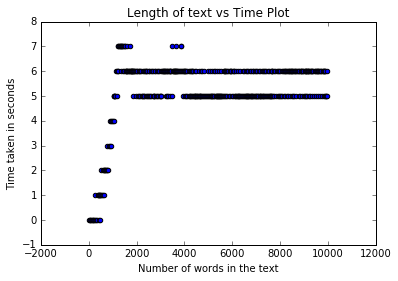

In [202]:
plt.scatter(length,diff)
plt.title('Length of text vs Time Plot')
plt.xlabel('Number of words in the text')
plt.ylabel('Time taken in seconds')

In [ ]:
plt.scatter(length,diff_graph)
plt.title('PLot of time taken by graph construction method')
plt.xlabel('Number of words')
plt.ylabel('Time taken in sec')

In [ ]:
plt.scatter(length,diff_textrank)
plt.title('PLot of time taken by graph construction method')
plt.xlabel('Number of words')
plt.ylabel('Time taken in sec')

The time taken to summarise a piece of text increases greatly on text size of greater than 1000 words. This can be reduced by generating only pairs of those sentences whos TF-IDF scores are greater than a certain threshold rather than generating all the permutations of sentences. Thus we use tf-idf mechanism to rate each of our sentences and proceed.

In [116]:
import wikipedia,unicodedata
theory = wikipedia.page('string theory')
content = unicodedata.normalize('NFKD', theory.content).encode('ascii','ignore')
with open('/home/najeeb/Desktop/theory.txt','wb') as fp:
    fp.write(content)

In [155]:
text = ''
with open('/home/najeeb/Desktop/theory.txt','rb') as fp:
    for line in fp:
        if len(line.strip()) > 0 and not line.startswith('='):
            text += line.strip()

In [161]:
print text

In physics, string theory is a theoretical framework in which the point-like particles of particle physics are replaced by one-dimensional objects called strings. It describes how these strings propagate through space and interact with each other. On distance scales larger than the string scale, a string looks just like an ordinary particle, with its mass, charge, and other properties determined by the vibrational state of the string. In string theory, one of the many vibrational states of the string corresponds to the graviton, a quantum mechanical particle that carries gravitational force. Thus string theory is a theory of quantum gravity.String theory is a broad and varied subject that attempts to address a number of deep questions of fundamental physics. String theory has been applied to a variety of problems in black hole physics, early universe cosmology, nuclear physics, and condensed matter physics, and it has stimulated a number of major developments in pure mathematics. Becau

In [165]:
a = Document(text)
a.construct_graph()
x = textrank_weighted(a.graph)

In [166]:
for i in x[0:10]:
    print i[0]
    print '-------------------------------------------'

String theory was first studied in the late 1960s as a theory of the strong nuclear force, before being abandoned in favor of quantum chromodynamics. Subsequently, it was realized that the very properties that made string theory unsuitable as a theory of nuclear physics made it a promising candidate for a quantum theory of gravity. The earliest version of string theory, bosonic string theory, incorporated only the class of particles known as bosons
-------------------------------------------
 Physicists studying string theory have discovered a number of these dualities between different versions of string theory, and this has led to the conjecture that all consistent versions of string theory are subsumed in a single framework known as M-theory.Studies of string theory have also yielded a number of results on the nature of black holes and the gravitational interaction. There are certain paradoxes that arise when one attempts to understand the quantum aspects of black holes, and work on

In [175]:
text = 'Cystic fibrosis affects 30,000 children and young adults in the US alone.'
sents = text.split('.')
data = ['.'.join(sents[i:i+3]) for i in range(0,len(sents),3)]

In [176]:
for i in data:
    print i
    print '---------------------------------'

Cystic fibrosis affects 30,000 children and young adults in the US alone.
---------------------------------
